This notebook aims to introduce

1. option pricing theory,
2. Monte Carlo method  and 
3. finite difference method

# Introduction to Option Pricing Theory

## Introduction to Quantitative Analyst (aka Quant)

There are two main branches in quantitative finance: $\mathbb{P}$ and $\mathbb{Q}$ worlds.

| | $\mathbb{P}$ world | $\mathbb{Q}$ world | 
| --- | --- | --- | 
| Application | risk and portfolio management | derivatives pricing | 
| Goal  | 'model the future' | 'extrapolate present' |
| Environment | real probability $\mathbb{P}$ | risk-neutral probability $\mathbb{Q}$ |
| Processes | discrete time series | continuous-time martingale |
| Dimension | large | low | 
|Tools | multivariate statistics | Ito calculus, PDE's |
| Challenges | estimation | calibration | 
| Business | buy-side (hedge fund) | sell-side (investment bank) | 

$$\text{Figure 1: Comparison between }\mathbb{P} \text{ and }\mathbb{Q} \text{ world} $$

| | Discrete-time | Continuous time | 
| --- | --- | --- | 
| Base Case  | Random walk | Levy (Brownion, Poisson) | 
| Autocorrelation | ARMA |  Ornstein-Uhlenbeck| 
| Volatililty Clustering | GARCH | Stochastic volatility and subordination | 

$$\text{Figure 2: Fundamental stochastic processes for the } \mathbb{P} \text{ and } \mathbb{Q} \text{ worlds} $$

Source: http://talus.maths.usyd.edu.au/u/UG/SM/MATH3075/r/Meucci_2011.pdf

## Vanilla Option Pricing Project

The purpose of this project is to implement the pricing of some vanilla options with the Black-Scholes model by multiple 
methods. 

In [2]:
# Import necessary libraries

import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from random import random
from random import randint
from random import seed

## Required classes and functions

This subsection contains all necessary classes to solve all problems in this project.
There are two classes: payOff and Option and 3 functions: GBM_formula, GBM_fd and monte_carlo.

In [3]:
class PayOff:
    def __init__(self, TheOptionsType_, Strike_):
        '''
        Inputs:
        =========
        TheOptionsType_: string (European call, European put, Binary call, Binary put)
        Strike_: float strike price
        '''
        
        self.__TheOptionsType = TheOptionsType_
        self.__Strike = Strike_
        
    def __call__(self,spot):
        # Overloading the ( ) operator
        '''
        inputs:
        =========
        spot: numpy array of spot prices
        
        
        returns:
        =========
        payoff value for each option 
        '''
        
        if self.__TheOptionsType == 'European call':
            return np.maximum(spot - self.__Strike,0)
        elif self.__TheOptionsType == 'European put':
            return np.maximum(self.__Strike - spot,0)
        elif self.__TheOptionsType == 'Binary call':
            return np.piecewise(spot, [spot < self.__Strike, spot >= self.__Strike], [0, 1])
        elif self.__TheOptionsType == 'Binary put':
            return np.piecewise(spot, [spot <= self.__Strike, spot > self.__Strike], [1, 0])
        else:
            raise Exception('Unknown option type found.')

In [4]:
class Option:
    def __init__(self, S, K, r, d, sigma, T):
        '''
        Parameters:
        ===========
        S: stock price 
        K: strike price
        r: risk-free interest rate
        d: dividend 
        sigma: volatility (implied)
        T: time to maturity
        
        
        Returns: 
        ===========
        Forward price, vanilla European call and put option' prices, cash-or-nothing call and put options' prices,
        zero coupon bond and forward contract.
        '''
        
        self.S = S
        self.K = K
        self.r = r
        self.d = d
        self.sigma = sigma
        self.T = T
        
        self.d1 = (np.log(self.S/self.K) + (self.r - self.d + self.sigma**2 / 2) * self.T) / (self.sigma * np.sqrt(self.T))
        self.d2 = self.d1 - self.sigma * np.sqrt(self.T)
    
    def forward_price(self):
        '''
        output forward price
        '''        
        return self.S * np.exp(self.r * self.T)
    
    def european_call(self):
        '''
        output vanilla European call option's price using Black-Scholes formula 
        '''        
        return self.S * np.exp(-self.d * self.T) * norm.cdf(self.d1) - self.K * np.exp(-self.r * self.T)*norm.cdf(self.d2)
    
    def european_put(self):
        '''
        output vanilla European put option's price using Black-Scholes formula 
        '''        
        return self.K * np.exp(-self.r * self.T)*norm.cdf(-self.d2) - self.S * np.exp(-self.d * self.T)*norm.cdf(-self.d1)
    
    def binary_call(self, face_value):
        '''
        output cash-or-nothing call option's price
        '''
        return face_value * np.exp(-self.r * self.T) * norm.cdf(self.d2)

    def binary_put(self, face_value):
        '''
        ouput cash-or-nothing put option's price
        '''
        return face_value * np.exp(-self.r * self.T) * norm.cdf(-self.d2)
    
    def zero_coupon_bond(self, face_value):
        '''
        output zero coupon bond's price based on the face value
        '''
        return face_value * np.exp(-self.r * self.T)
    
    def forward_contract(self):
        '''
        output forward contract's value
        '''
        return self.S * np.exp(-self.d * self.T) - self.K * np.exp(-self.r * self.T)
    
    def print_all_values(self, face_value):
        '''
        print prices of all options and zero coupon bond
        '''
        print('Forward price: {}'.format(self.forward_price()))
        print('European call: {}'.format(self.european_call()))
        print('European put: {}'.format(self.european_put()))
        print('Binary call: {}'.format(self.binary_call(face_value = 1)))
        print('Binary put: {}'.format(self.binary_put(face_value = 1)))
        print('Forward contract: {}'.format(self.forward_contract()))

In [5]:
def GBM_formula(S0, K, r, d, sigma, T, num_paths = 1):
    '''
    inputs:
    ===========
    
    S0: initial stock price
    K: strike price
    r: risk-free interest rate
    d: dividend
    sigma: volatility 
    T: time to maturity 
    num_paths: number of paths (integer)
    
    
    returns
    ===========
    
    numpy array containing stock price(s) at time T
    '''
    
    return S0 * np.exp((r - d - 0.5 * sigma ** 2) * T + sigma * np.sqrt(T) * np.random.standard_normal(num_paths))

In [6]:
def GBM_fd(S0, K, r, d, sigma, T, num_steps = 50, num_paths = 1, plot = False):
    '''
    Simulate Geometric Brownian Motion Stochastic Differential Equation using Euler'Maruyama method 
    to calculate terminal stock price
    
    
    inputs:
    ===========
    
    S0: initial stock price
    K: strike price
    r: risk-free interest rate
    d: dividend
    sigma: volatility 
    T: time to maturity 
    num_steps: numer of discretization steps
    num_paths: number of paths (integer)
    plot: plot of all paths generated
    
    
    returns:
    =========
    numpy array of terminal stock prices of all paths
    '''
    
    dt = T / num_steps
    
    if num_paths == 1:
        S_path = [0] * (num_steps + 1)        
    else:
        S_path = np.zeros((num_steps + 1, num_paths))
    
    S_path[0] = S0
    
    for i in range(1, num_steps + 1):
        S_path[i] = S_path[i-1] + (r-d) * S_path[i-1] * dt + S_path[i-1] * sigma * np.sqrt(dt) * np.random.standard_normal(num_paths)    
        
    if plot:
        plt.figure(figsize= (10,6))
        plt.plot(S_path)
        plt.xlabel('number of discretization steps')
        plt.ylabel('Stock price');
    
    return S_path[-1]

In [7]:
def monte_carlo(r, T, payoff, num_paths):
    '''
    Monte Carlo method:
    1. Average all payoffs at time T
    2. Discount the average using continuously compounded risk-free interest rate
    
    inputs:
    ===========
    
    r: risk-free interest rate
    T: time to maturity 
    payoff: numpy array of payoffs
    num_paths: number of paths (integer)
    
    
    returns
    ===========
    integer approximate price of an option 
    '''
    
    return np.exp(- r * T) * payoff.sum() / num_paths

In [8]:
def black_scholes_monte_carlo_pricer(option_type, S0, K, r, d, sigma, T, full_list = False, num_steps = 100, num_paths = 20):
    '''
    inputs:
    ==========
    
    option_type: string (European call, European put, Binary call, Binary put)
    S0: initial stock price
    K: strike price
    r: risk-free interest rate
    d: dividend
    sigma: volatility 
    T: time to maturity 
    num_steps: numer of discretization steps
    num_paths: number of paths (integer)
    
    
    returns:
    ==========
    
    Black-Scholes price of the option using monte carlo method
    '''
    
    mc = [0] * num_paths
    
    for num_path in range(1, num_paths + 1):
        # ST = GBM_formula(S0, K, r, d, sigma, T, 2**num_path)
        ST = GBM_fd(S0, K, r, d, sigma, T, num_steps, 2**num_path)
        payoff = PayOff(option_type, K)(ST)
        mc[num_path - 1] = monte_carlo(r, T, payoff, 2**num_path)
    
    if full_list:
        return mc
    
    return mc[-1]

**Geometric Brownian Motion Stochastic Differential Equation:**

$$dS_t = S_t (\mu -d ) dt + \sigma S_t dW_t$$
where $W_t$ is the standard Wiener process (Brownian motion).

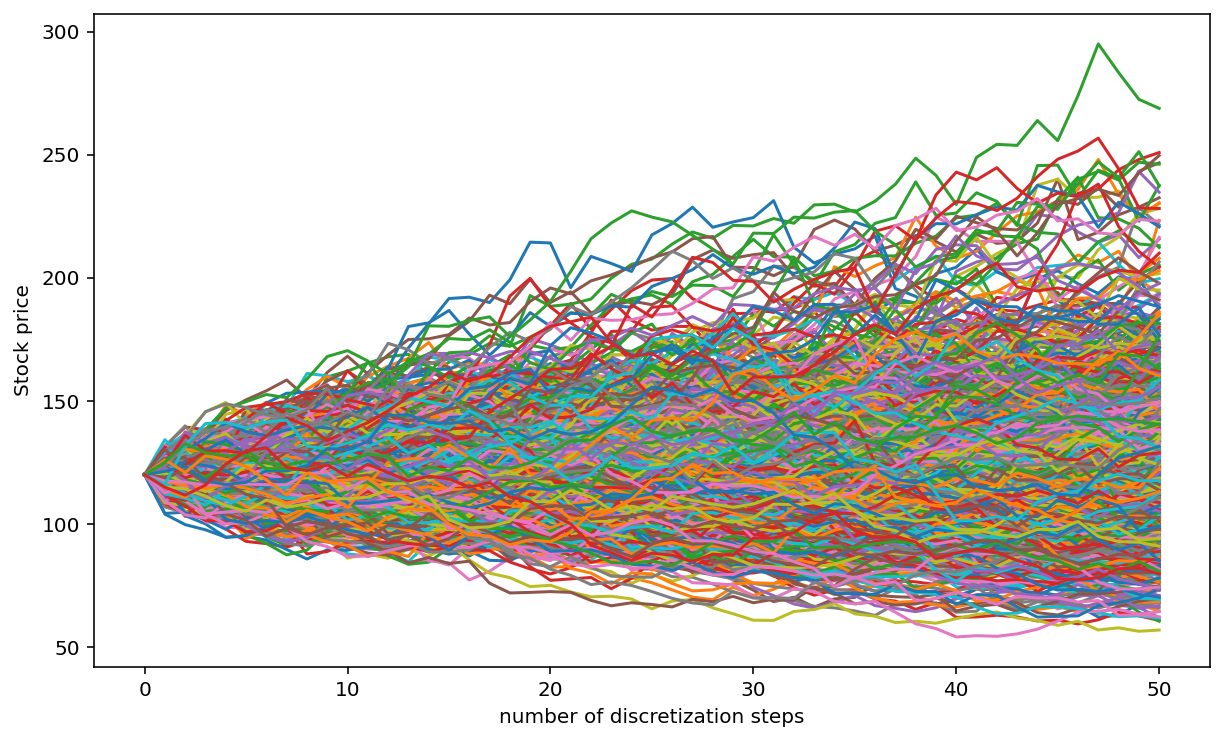

In [9]:
# Testing GBM_fd function and plot all possible paths of stock prices

S0 = 120
T = 1
K = 100
r = 0.05
d = 0
sigma = 0.25

num_paths = 10
num_steps = 50

_ = GBM_fd(S0, K, r, d, sigma, T, num_steps, 2**num_paths, plot = True)

# Project 1: Vanilla options in a Black-Scholes world

## Analytical formulas

The first thing to do is to implement the Black-Scholes formulas for various options:

* Implement the price of a forward as a function of time-to-maturity, $T$, continuously compounding rate, $r$, dividend rate, $d$, strike, $K$, spot, $S$, and volatility $\sigma$

* Ditto for a call option.
* Ditto for a put option.
* Ditto for a digital-call option.
* Ditto for a digital-put option.
* Ditto for a zero-coupon bond.

The following are the analytical formulas of each derivative.
\begin{align*}
\text{Forward price} & = Se^{rT}, \\
\text{European call option} & = Se^{-dT} N(d_1) - Ke^{-rT} N(d_2), \\
\text{European put option} & = -Se^{-dT} N(-d_1) + Ke^{-rT} N(-d_2), \\
\text{Digital-call option} & = ce^{-rT} N(d_2), \\
\text{Digital-put option} & = ce^{-rT} N(-d_2), \\
\text{Zero-coupon bond} & = ce^{-rT} \\
\text{Forward Contract} & = Se^{-dT} - Ke^{-rT}.
\end{align*}

All formulas above are implemented in the class Option. We need to test whether the class is executable.

In [10]:
# Testing the Option class

S = 120
K = 100
r = 0.05
d = 0.05
sigma = 0.2
T = 1
face_value = 1

Option(S, K, r, d, sigma, T).print_all_values(face_value)

Forward price: 126.1525315651229
European call: 21.067162301831587
European put: 2.0425738118173165
Binary call: 0.7528901356124418
Binary put: 0.1983392888882722
Forward contract: 19.02458849001428


The Option class is executable. 
Let us verify the consistency of those formulas.

## Consistency

We need to be sure that the formulas have been implemented correctly so we need to run the following consistency checks.

(i) **put-call parity with dividend**: $\text{Call } - \text{ Put } = \text{ Forward Contract}.$

(ii) The price of a call option should be monotone decreasing with strike, a convex function of strike and monotone increasing in volatility.

(iii) If $d = 0$, the call option price should be increasing with $T$. 

(iv) A call option price should be between $S$ and $S - K e^{-rT}$ for all inputs. (Note that it holds for non-dividend paying stock only)


(v) The price of a bull call-spread should approximate the price of a digital-call option.

(vi) The price of a digital-call option plus a digital-put option is equal to the price of a zero-coupon bond.

____

(i) **put-call parity with dividend**: $\text{Call } - \text{ Put } = \text{ Forward Contract}.$

Accuracy: 0.704


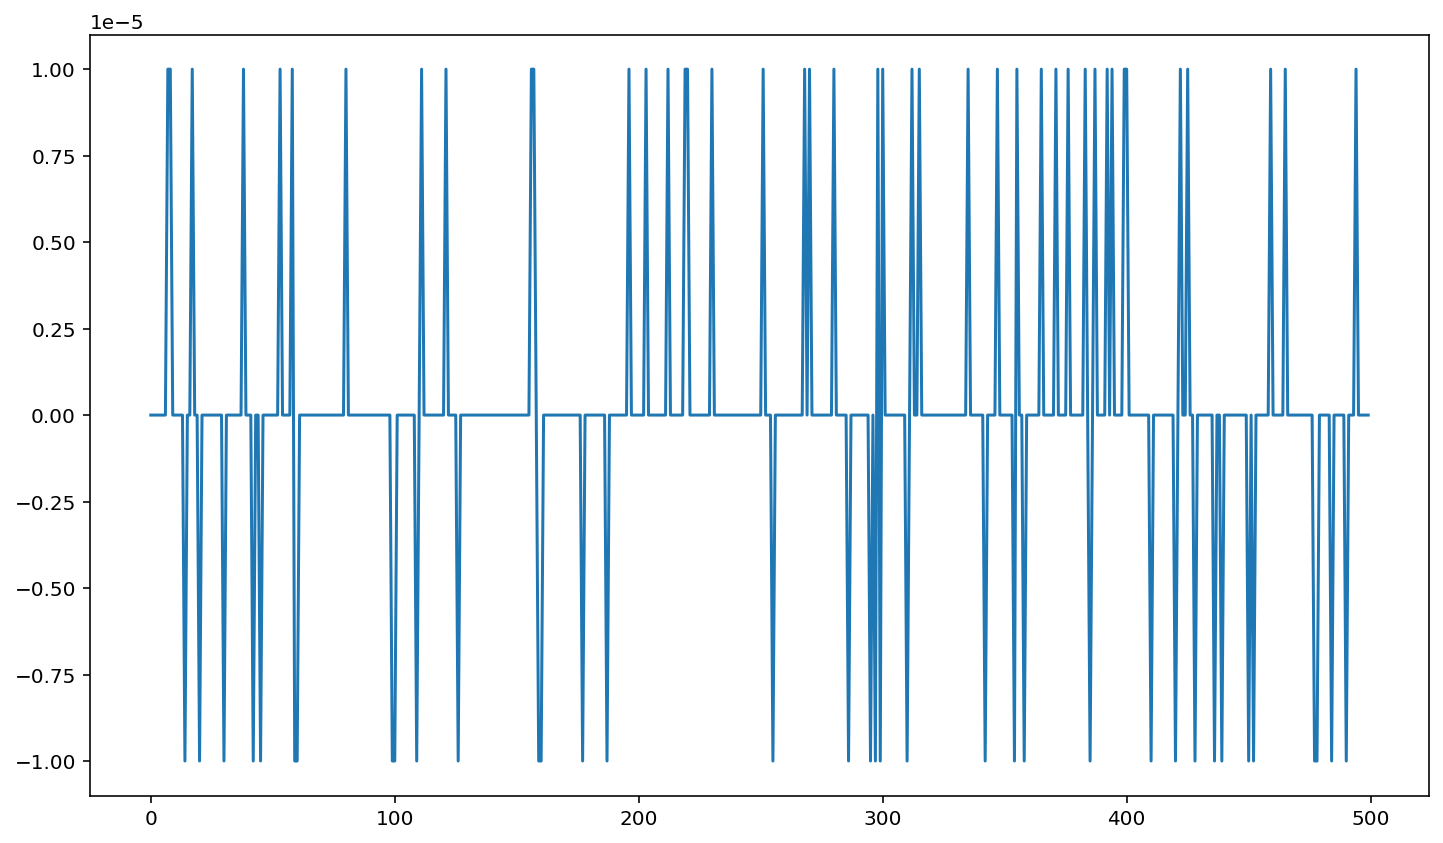

In [11]:
# verify put-call parity for vanilla European options

dec = 5       # number of decimal places of European call, put and forward contract
counter = 0   # number of agreed instances for put-call parity
loop = 500    # total number of trials

seed(1)

error = [0] * loop  # records error between call - put and forward contract

for i in range(loop):
    
    # # required paramters for Option class
    S = randint(1,100)
    K = randint(1,100)
    r = random()
    d = random()
    sigma = random()
    T = random()
    
    # calculate european call, put and forward contract 
    option = Option(S, K, r, d, sigma, T)
    c = round(option.european_call(), dec)
    p = round(option.european_put(), dec)
    f = round(option.forward_contract(),dec)
    
    # compare the values of call, put and forward contract
    # If they agree, then we increase the counter by 1
    # otherwise, we record the error
    
    if c - p == f:
        counter += 1
    else:
        error[i] = c - p - f
        
print('Accuracy:', counter / loop)
plt.plot(error);
# [x for x in error if x != 0]

(ii) The price of a call option should be monotone decreasing with strike, a convex function of strike and monotone increasing in volatility.

S:  31
K:  19
r:  0.5442292252959519
d:  0.625720304108054
sigma:  0.36995516654807925
T:  0.6039200385961945


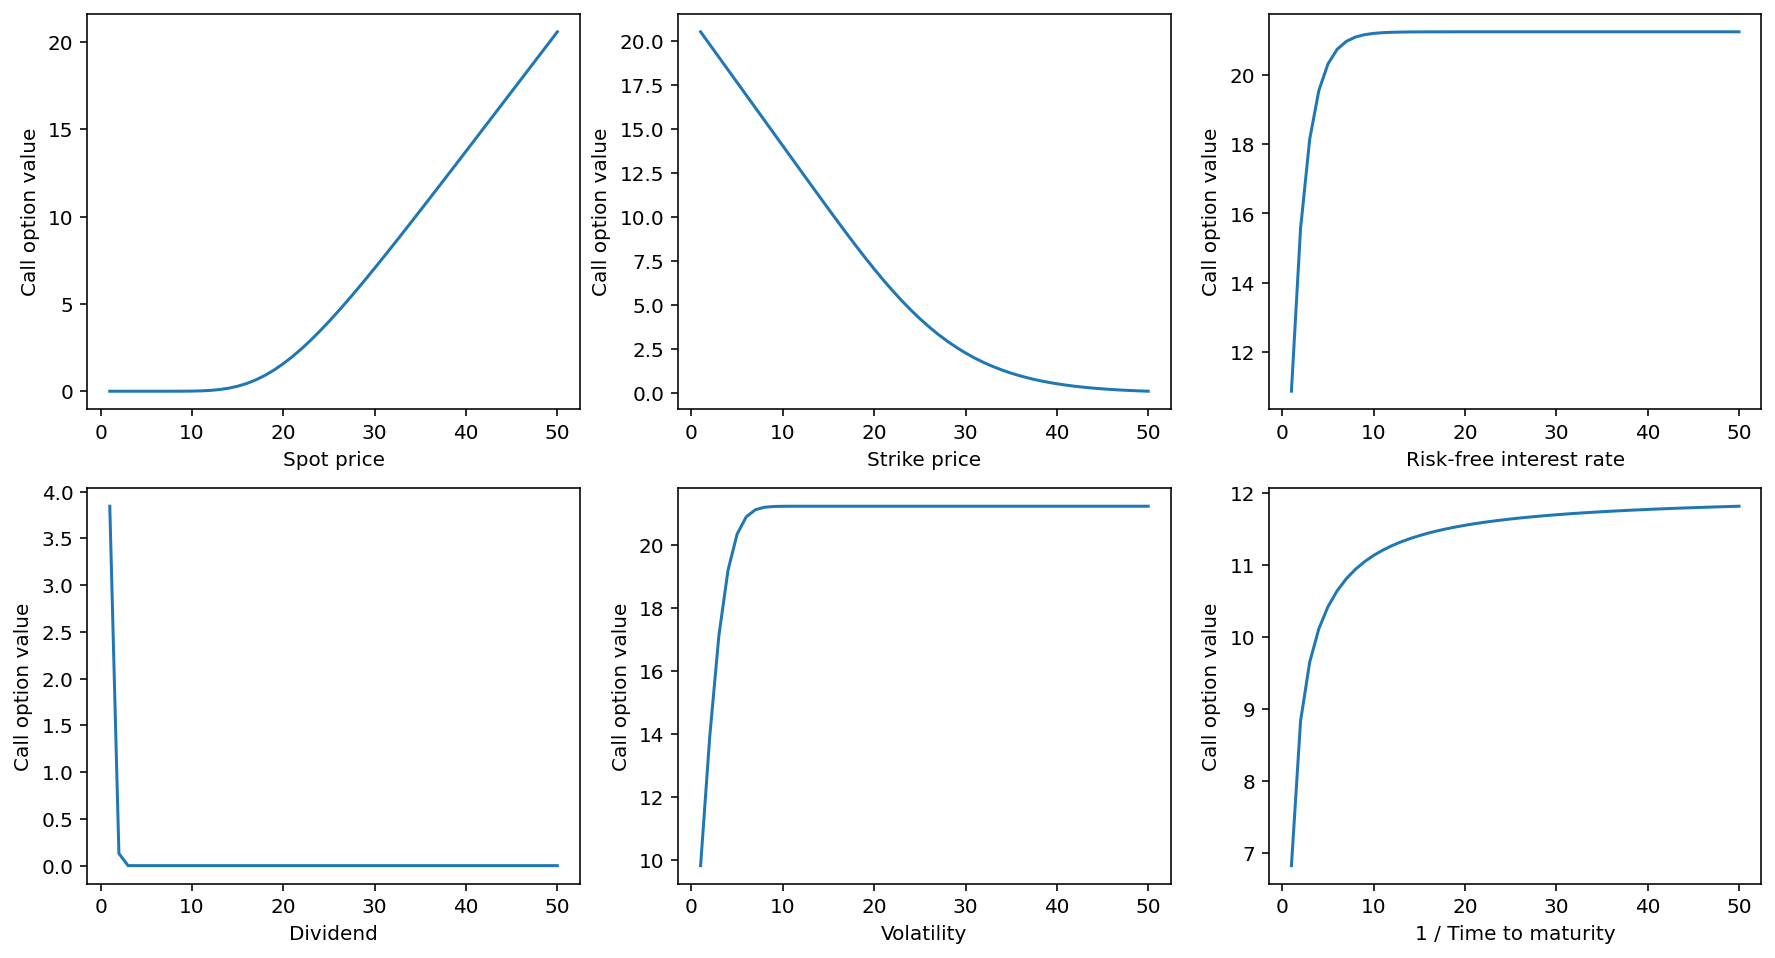

In [12]:
_, ax = plt.subplots(2,3, figsize = (15,8))

x_start = 1
x_end = 50
x_steps = x_end - x_start + 1

seed(3)

S = randint(1,100)
K = randint(1,S)     # we assume that spot price is always larger than strike price
r = random()
sigma = random()
T = random()
d = random()

print('S: ', S)
print('K: ', K)
print('r: ', r)
print('d: ', d)
print('sigma: ', sigma)
print('T: ', T)


x = np.linspace(x_start, x_end, x_steps)

f_spot = lambda x: Option(x, K, r, d, sigma, T).european_call()
f_strike = lambda x: Option(S, x, r, d, sigma, T).european_call()
f_interest = lambda x: Option(S, K, x, d, sigma, T).european_call()
f_dividend = lambda x: Option(S, K, r, x, sigma, T).european_call()
f_vol = lambda x: Option(S, K, r, d, x, T).european_call()
f_time = lambda x: Option(S, K, r, d, d, 1 / x).european_call()

y = [f_spot, f_strike, f_interest, f_dividend, f_vol, f_time]
variables = ['Spot price', 'Strike price', 'Risk-free interest rate', 'Dividend', 'Volatility', '1 / Time to maturity']

for i in range(6):
    ax[i//3, i%3].plot(x, y[i](x))
    ax[i//3, i%3].set_xlabel(variables[i])
    ax[i//3, i%3].set_ylabel('Call option value')

As shown by the graphs, our call option's value is indeed convex and monotonically decreasing with respect to strike price and monotonically increasing with respect to volatility.

**Application of convexity in determining arbitrage:**

**GS (Strategist)** (Interview question):

Given the following call options with their respective strike and costs, determine whether there exists an arbitrage opportunity.

| Options | Strike | Cost | 
| --- | --- | --- |
| $c_1$ | 10 | \$12 | 
| $c_2$ | 20 | \$7 | 
| $c_2$ | 30 | \$1 | 

Source: https://www.glassdoor.sg/Interview/Suppose-you-have-three-call-options-on-the-market-with-strikes-10-20-and-30-Suppose-the-call-option-with-strike-10-cos-QTN_224605.htm 

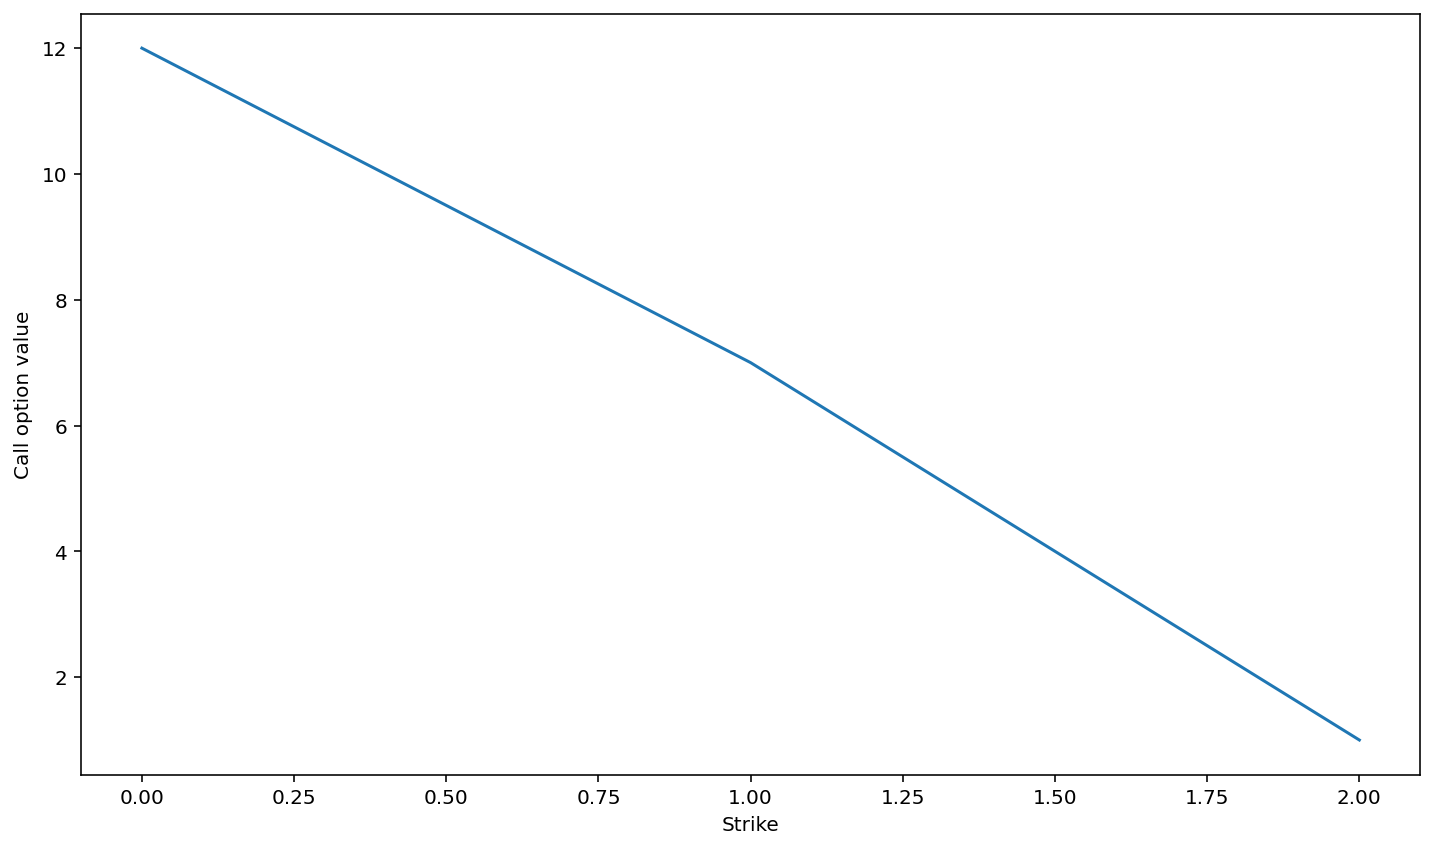

In [13]:
# Sketch of answer
# We rescale strike to 1,2,3 for 10, 20, 30 respectively since they are evenly spaced. 

plt.plot([12, 7, 1]);
plt.xlabel('Strike');
plt.ylabel('Call option value');

The graph above shows that call option value is not a convex function with respect to strike price, so there is an arbitrage opportunity. 

For a rigorous and mathematically inclined answer, please consult https://quant.stackexchange.com/a/22329/40934

**JPM (Quantitative Reseach Associate)** (Interview question)

How can you construct an arbitrage given these two call options(same maturity): 

| Options | Strike | Cost | 
| --- | --- | --- |
| $c_1$ | 40 | \$2 |
| $c_2$ | 30 | \$3 |

Source: https://www.glassdoor.com/Interview/how-can-you-construct-an-arbitrage-given-these-two-call-options-same-maturity-C1-strike-40-prize-now-4-C2-strike-30-QTN_2450726.htm

(iii) If $d = 0$, the call option price should be increasing with $T$.

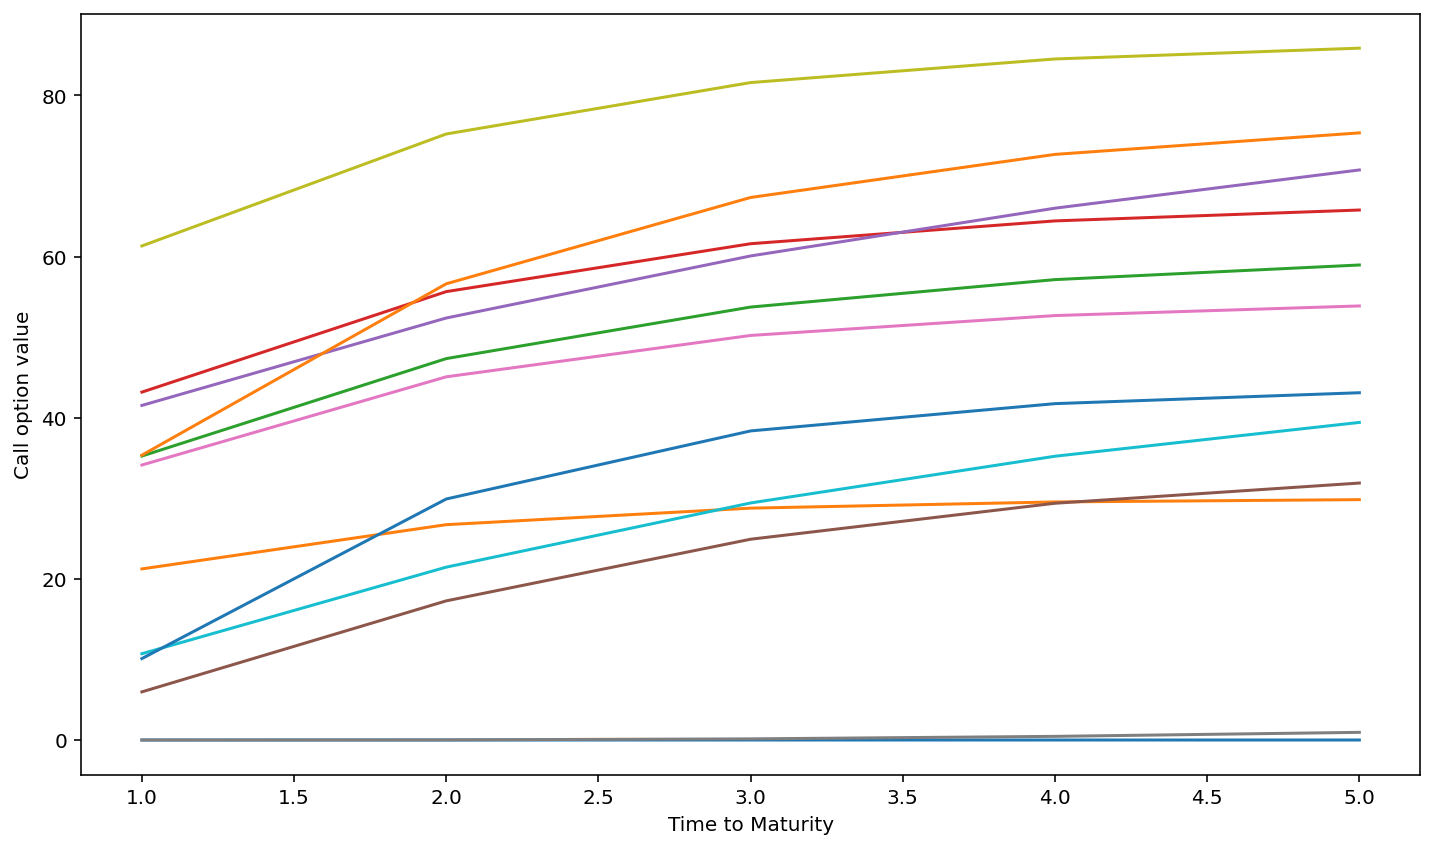

In [14]:
T_upper = 5
graph_num = 12
x = np.linspace(1, T_upper, T_upper)

d = 0

for j in range(graph_num):
    S = randint(1,100)
    K = randint(1,100)
    r = random()
    T = random()
    sigma = random()
    y = [Option(S, K, r, d, sigma, T).european_call() for T in range(1, T_upper+1)]
    plt.plot(x,y)
    plt.xlabel('Time to Maturity')
    plt.ylabel('Call option value')

(iv) A call option price should be between $S$ and $S - K e^{-rT}$ for all inputs. (Note that it holds for non-dividend paying stock only)

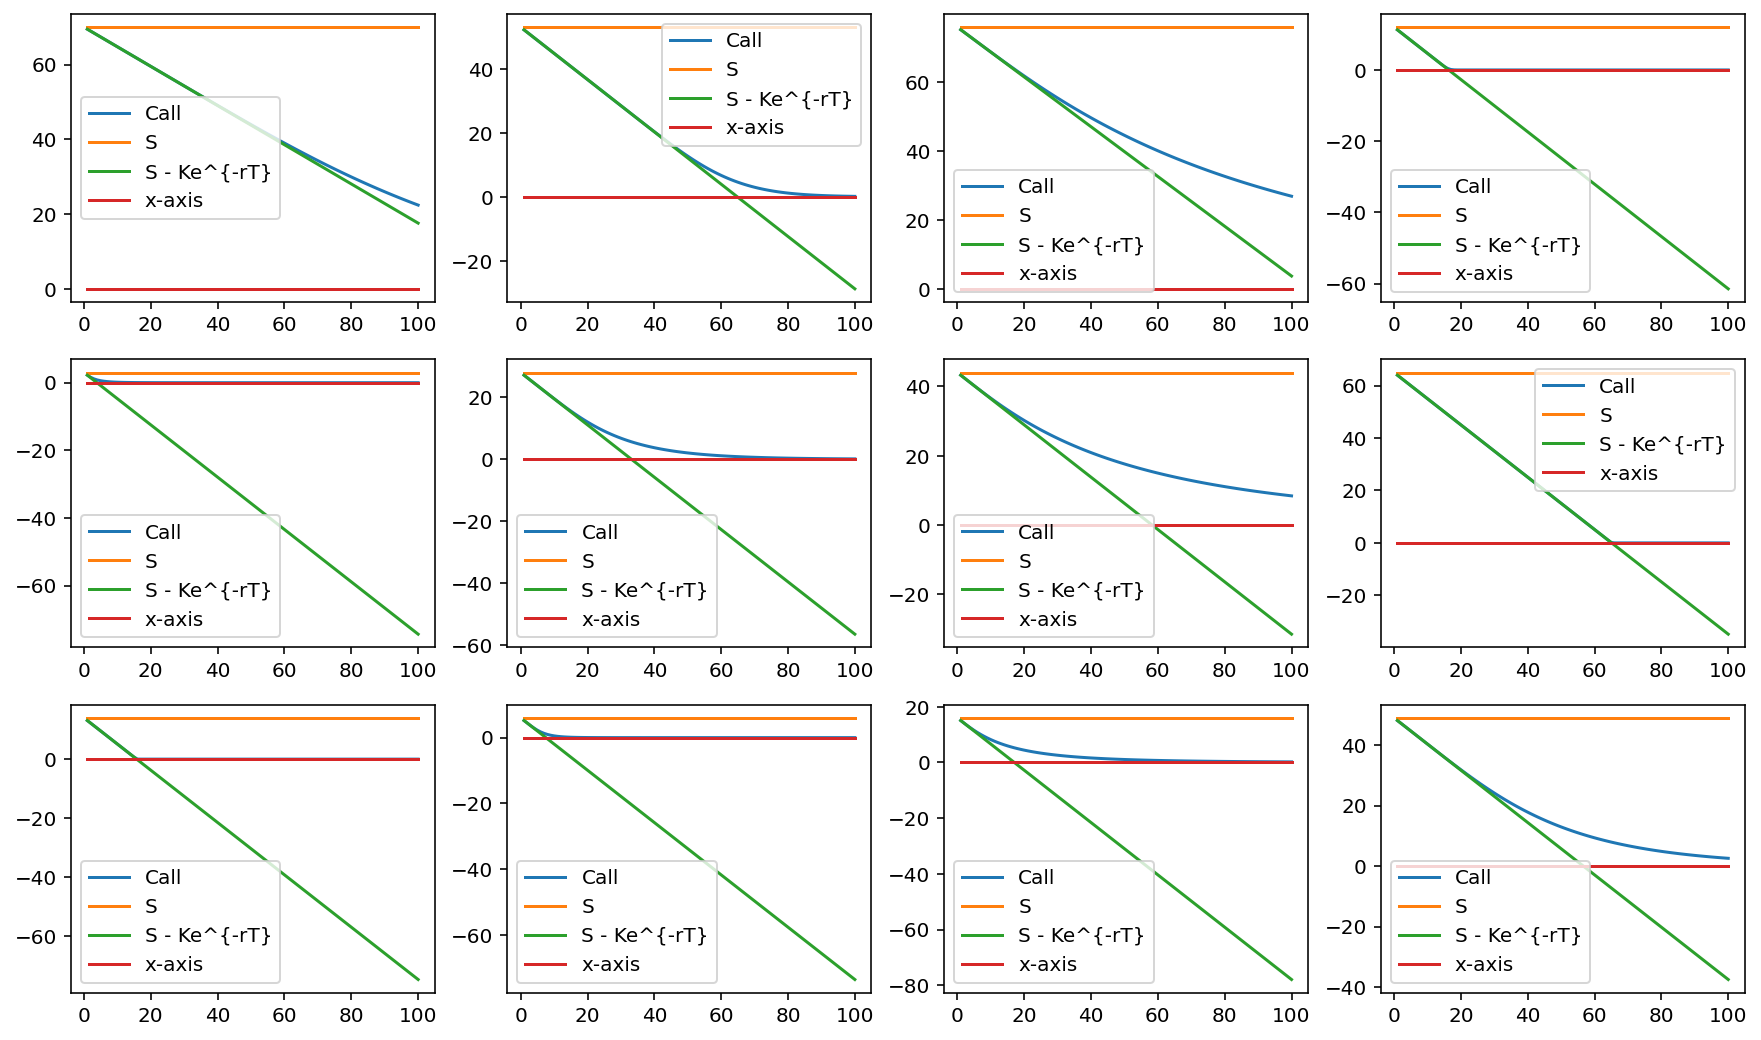

In [15]:
# Verify that S <= C <= S - Ke^{-rT} by plotting S, C and S - Ke^{-rT} on the same graph

# Note that the output is a grids with dimensions n_rows x n_cols where each element 
# is a graph containing all S, C and S - Ke^{-rT} on the same graph

n_rows = 3     # number of rows
n_cols = 4     # number of columns
K_upper = 100  # largest number of x-axis
graph_num = n_rows * n_cols    # total number of graphs
x = np.linspace(1, K_upper, K_upper)   # 
f, ax = plt.subplots(n_rows, n_cols, figsize = (15,9))

for j in range(graph_num):
    
    # required paramters for the Option class
    S = randint(1,100)
    r = random()
    sigma = random()
    T = random()
    d = 0
    
    # Calculate the corresponding call option values for different strike price by fixing S, r, sigma, T and d.
    y = [Option(S, K, r, d, sigma, T).european_call() for K in range(1, K_upper+1)]
    z = [S - K*np.exp(-r*T) for K in range(1, K_upper+1)]
    w = [S] * K_upper
    zero = [0] * K_upper
    
    # plot
    ax[j%n_rows, j%n_cols].plot(x,y, label = 'Call')
    ax[j%n_rows, j%n_cols].plot(x, w, label = 'S')
    ax[j%n_rows, j%n_cols].plot(x,z, label = 'S - Ke^{-rT}')
    ax[j%n_rows, j%n_cols].plot(x,zero, label='x-axis')
    ax[j%n_rows, j%n_cols].legend()

(v) The price of a bull call-spread should approximate the price of a digital-call option.

The **bull call spread**: long a call option $c_1$ with strike $K_1$ and short a call option $c_2$ with higher strike $K_2$ (i.e. $K_2>K_1$).

So, it has payoff 
$$(S-K_1)^+ - (S-K_2)^+ = \begin{cases} 
      0 & S\leq K_1, \\
      S-K_1 & K_1 < S\leq K_2, \\
      K_2-K_1 & S\geq K_2. 
   \end{cases}$$
Also, recall that digital-call option has payoff 
$$
\begin{cases} 
      0 & S\leq K_1, \\
      c & S > K_1.
   \end{cases}
   $$
where $c>0$ is the cash payout.

Practically speaking, digital-call option is discontinuous at $K$ whereas bull call spread is continuous everywhere. 
So, the former cannot be replicated using the latter, unless limit is involved here. 

When estimating, let $K_1= K$ and $K_2 = K_1 + c.$
Then the bull call spread will have payoff
$$\begin{cases} 
      0 & S\leq K, \\
      S-K & K < S\leq K+c, \\
      c & S\geq K+c, 
   \end{cases}$$
which is similar to digital call option payoff.

Source: https://quant.stackexchange.com/questions/1464/how-to-replicate-a-digital-call-option

![caption](https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Bull_spread_using_calls.png/450px-Bull_spread_using_calls.png)

Source: https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/Bull_spread_using_calls.png/450px-Bull_spread_using_calls.png

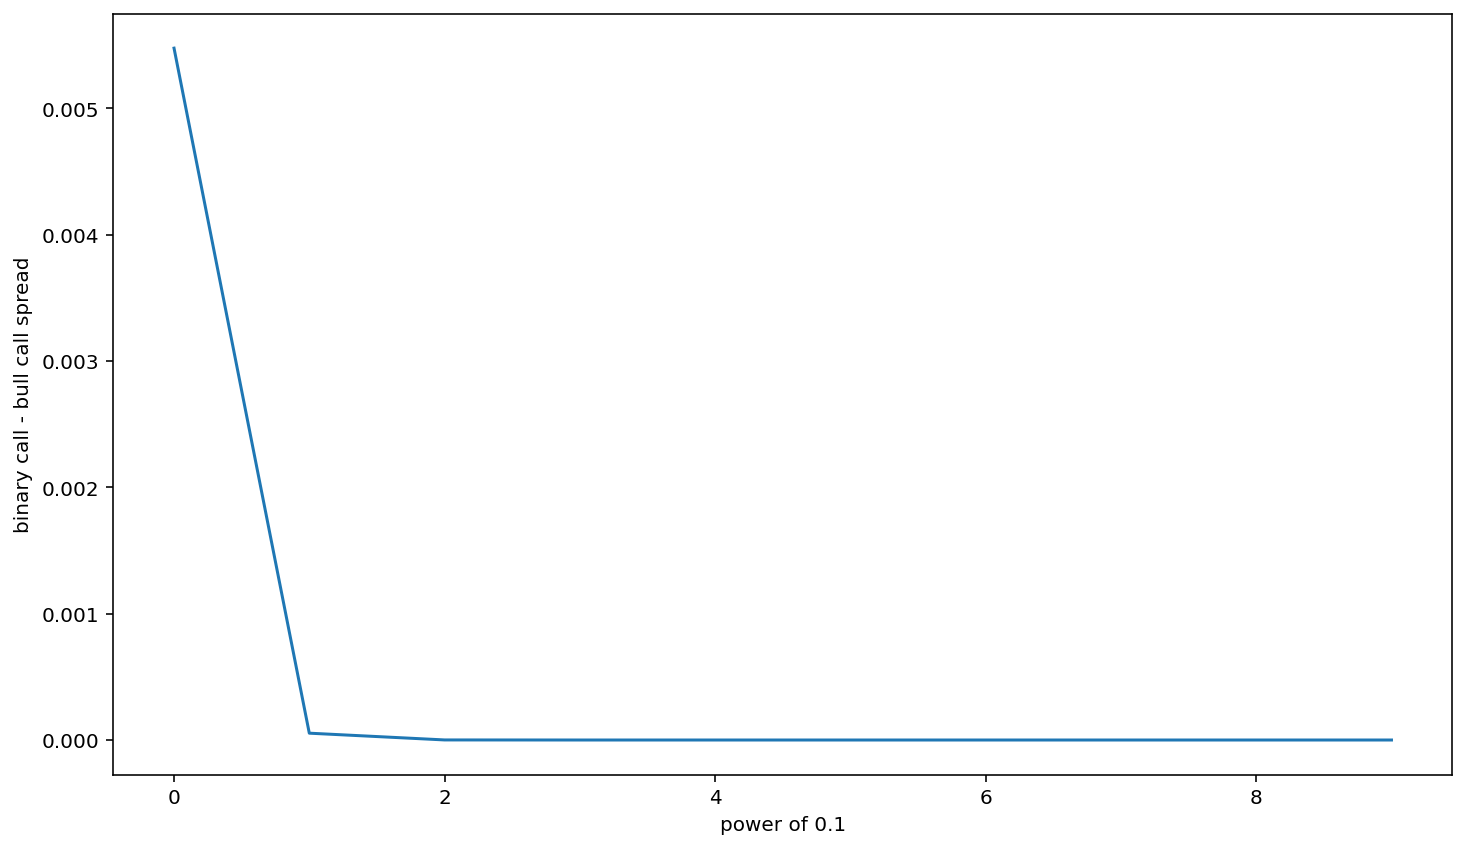

In [16]:
# To approximate a digital-call option using bull call-spread, 

loop = 10

# records the difference between bull-call spread and digital-call spread
diff = [0] * (loop)

e = 10

S = 120
K = 100
r = 0.05
d = 0
sigma = 0.2
T = 1
cash = 0.1**e


for i in range(loop):
    cash = 0.1**i
    
    # c_low = price of an European call with strike price K
    # c_high = price of an European call wiht slightly higher strike price K + cash
    c_low = Option(S, K, r, d, sigma, T).european_call()
    c_high = Option(S, K + cash, r, d, sigma, T).european_call()

    # price of a bull_call_spread
    bull_call_spread = c_low - c_high

    # price of a binary call 
    b_c = Option(S, K, r, d, sigma, T).binary_call(cash)

    diff[i] = b_c - bull_call_spread

    
plt.plot(diff)
plt.xlabel('power of 0.1')
plt.ylabel('binary call - bull call spread');

(vi) The price of a digital-call option plus a digital-put option is equal to the price of a zero-coupon bond.

In [17]:
# put-call parity for digital options

dec = 5
counter = 0 
loop = 500

seed(1)

error = [0] * loop

for i in range(loop):
    S = randint(1,100)
    K = randint(1,100)
    r = random()
    d = random()
    sigma = random()
    T = random()
    face_value = randint(1,100)
    b_c = round(Option(S, K, r, d, sigma, T).binary_call(face_value),dec)
    b_p = round(Option(S, K, r, d, sigma, T).binary_put(face_value), dec)
    z = round(Option(S, K, r, d, sigma, T).zero_coupon_bond(face_value), dec)
#    print(' {:>12}, {:>12}, {}'.format(z, b_c + b_p,  b_c + b_p == z))
    if b_c + b_p == z:
        counter += 1
    else:
        error[i] = b_c + b_p - z

print('Accuracy:', counter / loop)
plt.plot(error);
# [x for x in error if x != 0]

Accuracy: 0.678


## Validation via Monte Carlo

(i) We implemented an engine which randomly evolves a stock price from time $0$ to time $T$ according to a geometric Brownian motion with drift $r - d$, and volatility $\sigma$. 
Use the formula
$$S_T = S_0 e^{(r-d- \frac{1}{2}\sigma^2)T  + \sigma \sqrt{T} Z}$$
where $Z$ is a standard normal random variable.

In [17]:
# Please refer to GBM_formula function above

(ii) We use the engine to write Monte Carlo pricers for all the products mentioned above. 
The engine generates a final stock value. 
The option's pay-off for that final value is then evaluated and discounted. 
These values are then averaged over a large number of paths. 
Get it to return the price for successive powers of two for the number of paths so you can see the convergence. 
Also get it to return the variance of the samples and standard error.

We implemented the pricer and the engine in an orthogonal way so that the engine just takes in an option object which states its pay-off and expiry. 
The engine should then need no modifications when a new option type, such as a straddle, is added in. 
Also the option objects can then be reused when doing Monte Carlo simulations based on different engines.

In [0]:
S0 = 120
T = 1
K = 100
r = 0.05
d = 0
sigma = 0.25
face_value = 1

option_types = ('European call', 'European put', 'Binary call', 'Binary put')

# Black-Scholes prices
opt = Option(S0, K, r, d, sigma, T)
BS = [opt.european_call(), opt.european_put(), opt.binary_call(face_value), opt.binary_put(face_value)]
    

num_paths = 20
num_steps = 100

mc_values = {}

for option_type in option_types:
    mc_values[option_type] = black_scholes_monte_carlo_pricer(option_type, S0, K, r, d, sigma, T, True, num_steps, num_paths)
            
f, ax = plt.subplots(2,2, figsize = (15,8))

for i, option in enumerate(option_types):
    ax[i//2, i%2].plot(mc_values[option], label = option + ' (Monte Carlo)')
    ax[i//2, i%2].axhline(mc_values[option][-1], label = 'final mc value: ' + str(mc_values[option][-1]), c = 'g')
    ax[i//2, i%2].axhline(BS[i], label = 'True value:' + str(BS[i]), c = 'r')
    ax[i//2, i%2].set_xlabel('Number of paths (power of 2)')
    ax[i//2, i%2].set_ylabel('Monte Carlo values')
    ax[i//2, i%2].legend()

We can now run some tests.

(i) Compute Monte Carlo and formula prices for a large range of inputs for each of the options above. 
They should all agree up to the degree of convergence of the Monte Carlo.


If the above tests worked, we can be reasonably confident in both our Black-Scholes functions and in our Monte Carlo engine.

In [0]:
# Compare analytical price and Monte Carlo price of the European call option for different inputs
# To test other types of options, change option_type and Option class (line 18)
# option_type = 'put'

option_types = ('European call', 'European put', 'Binary call', 'Binary put')
loop = 50
num_paths = 20
diff = {key: [0] * loop for key in option_types} 

face_value = 1

# monte carlo values
mc = {}

f, ax = plt.subplots(2,2, figsize = (15,8))

for i in range(loop):
    S0 = randint(1,100)
    K = randint(1,100)
    r = random()
    d = random()
    sigma = random()
    T = random()
    
    c = Option(S0, K, r, d, sigma, T).european_call()
    p = Option(S0, K, r, d, sigma, T).european_put()
    b_c = Option(S0, K, r, d, sigma, T).binary_call(face_value)
    b_p = Option(S0, K, r, d, sigma, T).binary_put(face_value)
    
    bs = [c, p, b_c, b_p]
    
    for j, option_type in enumerate(option_types):
        mc[option_type] = [0] * (num_paths -1 )

        for num_path in range(1, num_paths):
            ST = GBM_formula(S0, K, r, d, sigma, T, 2**num_path)
            payoff = PayOff(option_type, K)(ST)
            mc[option_type][num_path - 1] = monte_carlo(r, T, payoff, 2**num_path)

        diff[option_type][i] = bs[j] - mc[option_type][-1]    


for k, option_type in enumerate(option_types):
    ax[k//2,k%2].plot(diff[option_type], label = option_type)
    ax[k//2,k%2].axhline(0, c = 'r')
    ax[k//2,k%2].set_xlabel('Number of loops')
    ax[k//2,k%2].set_ylabel('Black-Scholes prices - MC values')
    ax[k//2,k%2].legend()

From graphs above, it seems that differences for all options above are very small (negligible). 
So, we are confident that our Monte Carlo pricer is correct.

## Investigations

We can now use these routines to do some investigations.

How does the Black-Scholes price of a call option vary as a function of volatility? 
What happens when volatility is zero, or volatility is very large?

In [0]:
show_asymptote = True

sigma_upper = 100
x = np.linspace(1, sigma_upper, sigma_upper)

S = 110
K = 100
r = 0.05
d = 0.05
T = 1

f, ax = plt.subplots(1, 2, figsize = (15,5))


y_no_div_inv = [Option(S, K, r, 0, 1 / sigma, T).european_call() for sigma in range(1, sigma_upper + 1)]
S_no_div_inv = [np.exp(-r*T) * np.max( (S * np.exp(r * T) - K ), 0 )] * sigma_upper

y_with_div_inv = [Option(S, K, r, d, 1 / sigma, T).european_call() for sigma in range(1, sigma_upper + 1)]
S_with_div_inv = [np.exp(-r*T) * np.max( (S * np.exp( (r-d) * T) - K ), 0 )] * sigma_upper


y_no_div = [Option(S, K, r, 0, sigma, T).european_call() for sigma in range(1, sigma_upper + 1)]
S_no_div = [S] * sigma_upper

y_with_div = [Option(S, K, r, d, sigma, T).european_call() for sigma in range(1, sigma_upper + 1)]
S_with_div = [S * np.exp(-d*T)] * sigma_upper


starting_value = 0

ax[0].plot(x[starting_value:], y_no_div_inv[starting_value:], label='No dividend')
ax[0].plot(x[starting_value:], y_with_div_inv[starting_value:], label='With dividend')
if show_asymptote:
    ax[0].plot(x[starting_value:], S_no_div_inv[starting_value:], label='Stock price without dividend')
    ax[0].plot(x[starting_value:], S_with_div_inv[starting_value:], label='Stock price with dividend')
ax[0].set_xlabel('1 / volatility')
ax[0].set_ylabel('European Call option value')
ax[0].set_title('Zero volatility')
ax[0].legend();


ax[1].plot(x[starting_value:], y_no_div[starting_value:], label='No dividend')
ax[1].plot(x[starting_value:], y_with_div[starting_value:], label='With dividend')
if show_asymptote:
    ax[1].plot(x[starting_value:], S_no_div[starting_value:], label='Stock price without dividend')
    ax[1].plot(x[starting_value:], S_with_div[starting_value:], label='Stock price with dividend')
ax[1].set_xlabel('Volatility')
ax[1].set_ylabel('European Call option value')
ax[1].set_title('Infinite volatility')
ax[1].legend();

Intuitively, if volatility is zero, then stock price behaves like a money market account (riskless bond) since there is no randomness.
Therefore, $$S_T = S_0e^{ (r-d)T}$$
Since there is no randomness in $e^{-rT} (S_0 e^{ (r-d)T} - K)^+,$ so the expectation operator does nothing. 
It follows that the risk-neutral pricing of European call option is
$$\text{European call option value } = \mathbb{E}[ e^{-rT} (S_T - K)^+] = \mathbb{E}[ e^{-rT} (S_0 e^{ (r-d)T} - K)^+] = e^{-rT} (S_0 e^{ (r-d)T} - K)^+ $$


On the other hand, as volatility tends to infinity, European call option value will tend to $S_0e^{-dT}$.

## Stepping methods (Euler-Maruyama)

One further thing to implement is an alternative engine based on Euler stepping.
Divide the time, $T$, into a large number of steps, $N$. 
Let $$\Delta T = \frac{T}{N}.$$
Evolve the stock price across each step by
$$S_{(j+1)\Delta T} = S_{j\Delta T} + (r-d)S_{j\Delta T}\Delta T + S_{j\Delta T} \sigma \sqrt{\Delta T}W_j,$$
where the $W_j$ are independent normal variables. 
Running up to the last step this gives an alternate way of generating the final stock value. 
Use this to develop pricers for the basic options above. 
The engine will need as inputs the number of steps and the number of paths.

In [0]:
S0 = 120
T = 1
K = 100
r = 0.05
d = 0
sigma = 0.25
face_value = 1

option_types = ('European call', 'European put', 'Binary call', 'Binary put')

# Black-Scholes prices
opt = Option(S0, K, r, d, sigma, T)
BS = [opt.european_call(), opt.european_put(), opt.binary_call(face_value), opt.binary_put(face_value)]
    

num_paths = 20
num_steps = 100

# monte carlo values
mc_values = {}


for option_type in option_types:
    mc_values[option_type] = black_scholes_monte_carlo_pricer(option_type, S0, K, r, d, sigma, T, True, num_steps, num_paths)
            
f, ax = plt.subplots(2,2, figsize = (15,8))

for i, option in enumerate(option_types):
    ax[i//2, i%2].plot(mc_values[option], label = option + ' (Monte Carlo)')
    ax[i//2, i%2].axhline(mc_values[option][-1], label = 'final mc value: ' + str(mc_values[option][-1]), c = 'g')
    ax[i//2, i%2].axhline(BS[i], label = 'True value:' + str(BS[i]), c = 'r')
    ax[i//2, i%2].set_xlabel('Number of paths (power of 2)')
    ax[i//2, i%2].set_ylabel('Monte Carlo values')
    ax[i//2, i%2].legend()